In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

In [3]:
df = pd.read_csv("Fraud.csv")

In [4]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Lets get the info about the data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


* As we can observe that columns 
    1) int64 - step,isFraud,isFlaggedFraud
    2) float64 - used for balances and amount
    3) object - sring/text. Used for transaction type(type) and account ids(nameOrig, nameDest)

## Descriptive Statistics to Know More About Its Mean and Distribution

In [6]:
df.describe().round(2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6.362620e+06,6.362620e+06,6362620.00,6362620.0
mean,243.40,179861.90,833883.10,855113.67,1.100702e+06,1.224996e+06,0.00,0.0
std,142.33,603858.23,2888242.67,2924048.50,3.399180e+06,3.674129e+06,0.04,0.0
min,1.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
25%,156.00,13389.57,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
50%,239.00,74871.94,14208.00,0.00,1.327057e+05,2.146614e+05,0.00,0.0
75%,335.00,208721.48,107315.18,144258.41,9.430367e+05,1.111909e+06,0.00,0.0
max,743.00,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.00,1.0


Key observation
- **Transaction Amount**:
    - Mean = 179861.90, but the maximum goes to 92 million (9292445516.64)
    - Indicating a highly skewed distribution with a few very large transaction

- **Balances**:
    - very large ranges
    - Mean balances are in the range of 800k - 1.2M , Distribution is skewed
    - In 156 steps we have 25% of transaction are less than 13k all the columns (oldbalanceOrg	newbalanceOrig	oldbalanceDest	newbalanceDest) = 0.00

- **IsFraud**:
    - Around 0.00129 ~ 0.13% (df['isFraud'].mean()) are Fraud
    - Out of 6362620, 8213 (df['isFraud'].sum()) are Fraud

- **IsFlaggedFraud**:
    - Around 0.0002% is (df["isFlaggedFraud"].mean()*100) Flagged Fraud
    - Out of 6362620, 16 (df["isFlaggedFraud"].sum()) are Flagged Fraud
    - this means 16 rows which is very rear

## Data Cleaning

* How many missing values are there

In [7]:
print(f"Data has this many missing values:")
df.isnull().sum()

Data has this many missing values:


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

* Skewness of the data

In [8]:
num_cols=list(df.select_dtypes(include=np.number))
num_cols

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

* We are using sample of 100000 just to get the view of the distribution and it saves compute rather than taking 6362620

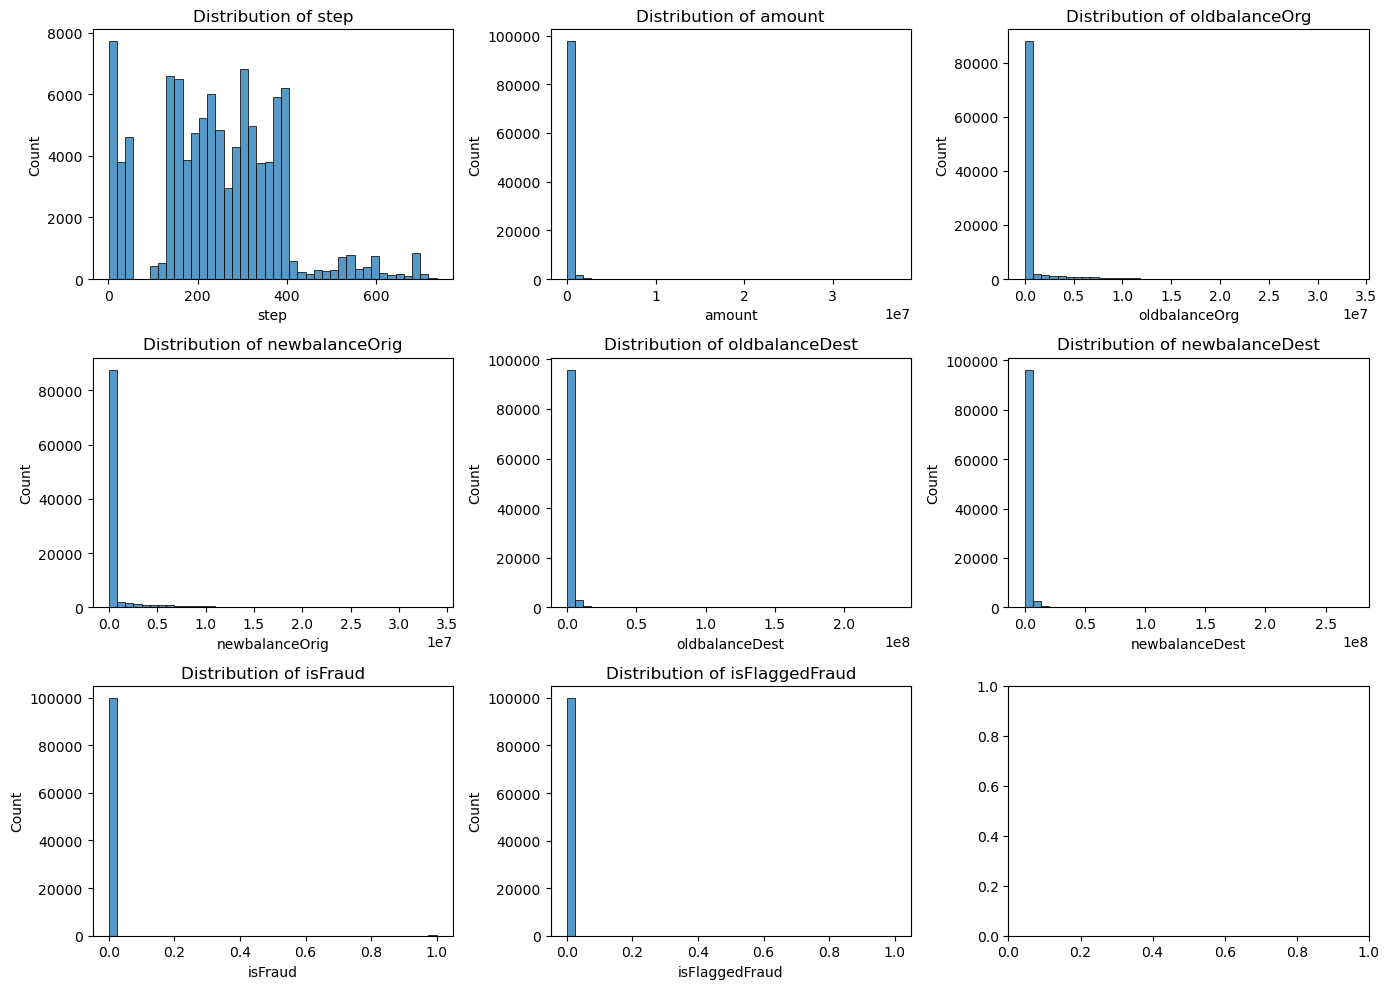

In [9]:
sample_df = df.sample(100000, random_state=42)

fig, axes = plt.subplots(3, 3, figsize=(14, 10))

for i, col in enumerate(num_cols):
    r, c = divmod(i, 3)
    sns.histplot(sample_df[col], bins=40, ax=axes[r][c], kde=False)
    axes[r][c].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

* Skewness of the numerical columns before applying log transformation

In [10]:
for i in num_cols:
    print(f"Skewness of {i}: {df[i].skew()}")

Skewness of step: 0.37517688846984765
Skewness of amount: 30.99394948249038
Skewness of oldbalanceOrg: 5.249136420603121
Skewness of newbalanceOrig: 5.176884001159233
Skewness of oldbalanceDest: 19.921757915791062
Skewness of newbalanceDest: 19.352302057660165
Skewness of isFraud: 27.779538153063452
Skewness of isFlaggedFraud: 630.6036294703543


Key Obervation
- **Skewness Values**
    - less than 0 : negatively skewed (left skew)
    - Near 0 : distiribution is symmetric (normal distrbution)
    - 0.5 to 1 : moderate skew
    - more than 1 : positive skew (right skew)
- **Results**
    - step : normal
    - amount : extremely skewed
    - oldbalanceOrg : skewed
    - newbalanceOrig : skewed
    - oldbalanceDest : highly skewed
    - newbalanceDest : highly skewed
    - isFraud : this is binary (0/1)
    - isFlaggedFraud : this is binary (0/1)

To fix this, we can apply a **log transformation** (`np.log1p`, which is `log(1+x)` to handle potential zero values). This transformation compresses the range of large values, making the distribution more symmetrical and closer to a normal distribution.

In [11]:
num_cols=[ 'amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

In [12]:
for i in num_cols:
    df[i]=np.log1p(df[i])

* Skewness of the numerical columns after applying log transformation

In [13]:
for i in num_cols:
    print(f"Skewness of {i}: {df[i].skew()}")

Skewness of amount: -0.5550183204227738
Skewness of oldbalanceOrg: -0.25972282464865
Skewness of newbalanceOrig: 0.44014809990739817
Skewness of oldbalanceDest: -0.21326075958033924
Skewness of newbalanceDest: -0.3869372982497443


Key Obervation
- **Skewness Values**
    - less than 0 : negatively skewed (left skew)
    - Near 0 : distiribution is symmetric (normal distrbution)
    - 0.5 to 1 : moderate skew
    - more than 1 : positive skew (right skew)
- **Results**
    - step : normal
    - amount : small negative skew
    - oldbalanceOrg : very close to normal
    - newbalanceOrig : very close to normal
    - oldbalanceDest : very close to normal
    - newbalanceDest : very close to normal
    - isFraud : this is binary (0/1)
    - isFlaggedFraud : this is binary (0/1)

Dealing with Outliers

In [14]:
print(f"we have these numeric columns {', '.join(num_cols)}")

we have these numeric columns amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest


In [15]:
print(f"Number of rows before removing outliers {df.shape[0]}")

Number of rows before removing outliers 6362620


In [16]:
#removing outliers

for i in num_cols:
    Q1=df[i].quantile(0.25)
    Q3=df[i].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1 - 1.5 * IQR
    upper_bound=Q3 + 1.5 * IQR
    df = df[(df[i] >= lower_bound) & (df[i] <= upper_bound)]

In [17]:
print(f"Number of rows after removing outliers {df.shape[0]}")

Number of rows after removing outliers 6330191


## EDA

Understanding Multicollinearity using correlation matrix

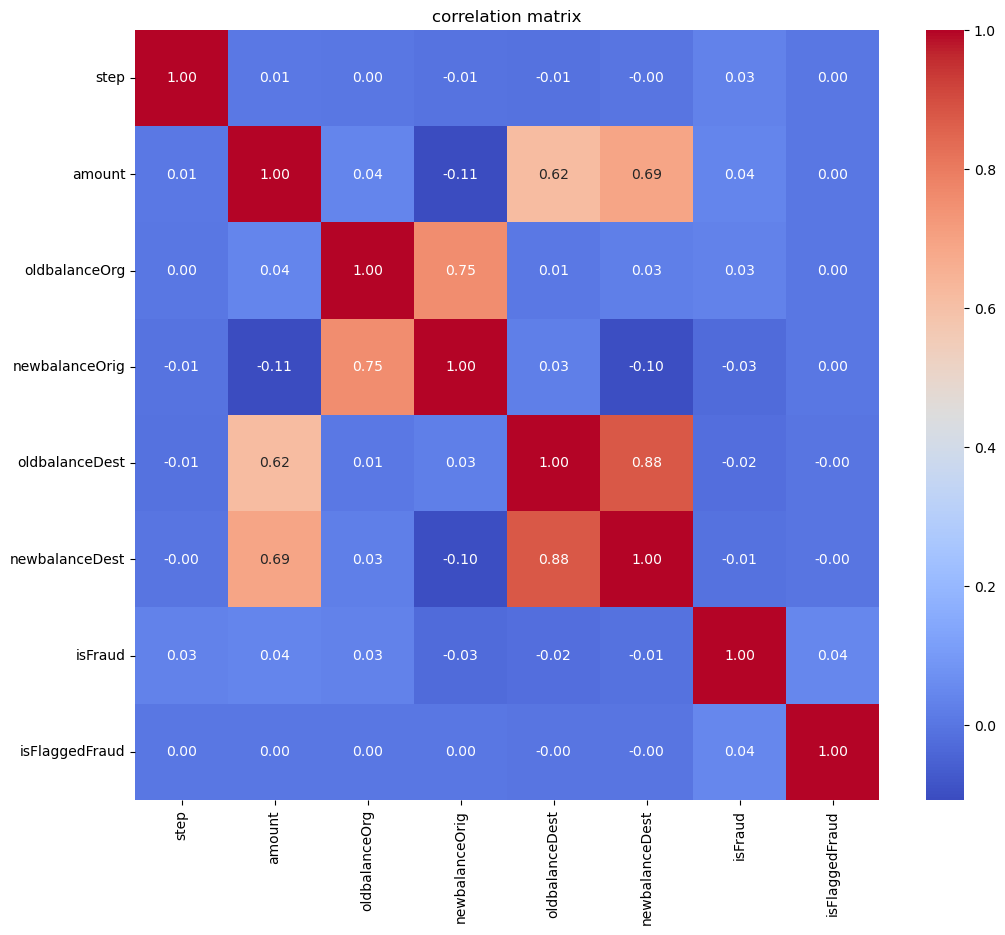

In [18]:
corrmat=df.corr(numeric_only=True)
plt.figure(figsize=(12,10))
sns.heatmap(corrmat,annot=True,cmap='coolwarm', fmt='.2f')
plt.title("correlation matrix")
plt.show()

Key Obervation
- **High Correlations (close to 1.0 or -1.0)**
    - oldbalanceOrg and newbalanceOrig → 0.75 → Strong positive correlation (makes sense: balances before and after transaction are linked).
    - oldbalanceDest and newbalanceDest → 0.88 → Very strong positive correlation (destination balances are tightly related).
    - amount with oldbalanceDest (0.62) and with newbalanceDest (0.69) → The transferred amount strongly affects destination balances.
- **Low / Near Zero Correlations**
    - step with almost everything else (~0.0) → time step doesn’t explain much directly.
    - isFraud has very weak correlation (0.03, 0.04, etc.) with all numeric features → means fraud detection is not linearly related to these variables
- **Features**
    - Since oldbalanceDest and newbalanceDest are highly correlated (0.88), including both may cause multicollinearity in linear models might drop one or use PCA/regularization to handle it
- **Target Variable (isFraud):**
    - Correlation values are near zero → fraud is not obvious from simple numeric relationships.

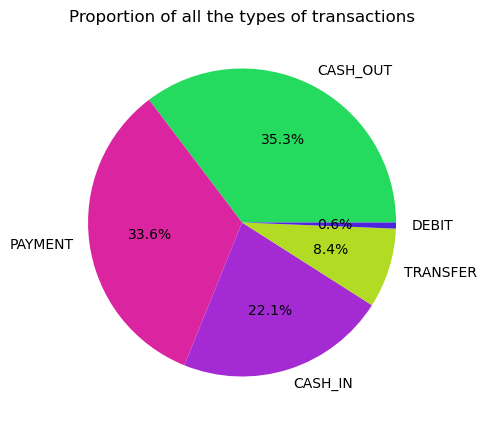

In [19]:
plt.figure(figsize=(6,5))
type_count = df['type'].value_counts()
plt.pie(type_count,labels=type_count.index, autopct='%1.1f%%', startangle=0, colors=['#24DB5F', '#DB24A0','#A42BD4','#B2DC23','#4D23DC'])
plt.title('Proportion of all the types of transactions')
plt.show()

**Insight:** The transaction in the dataset are dominated by PAYMENT , CASH_IN , CASH_OUT, which make up round 91% of the total transactions

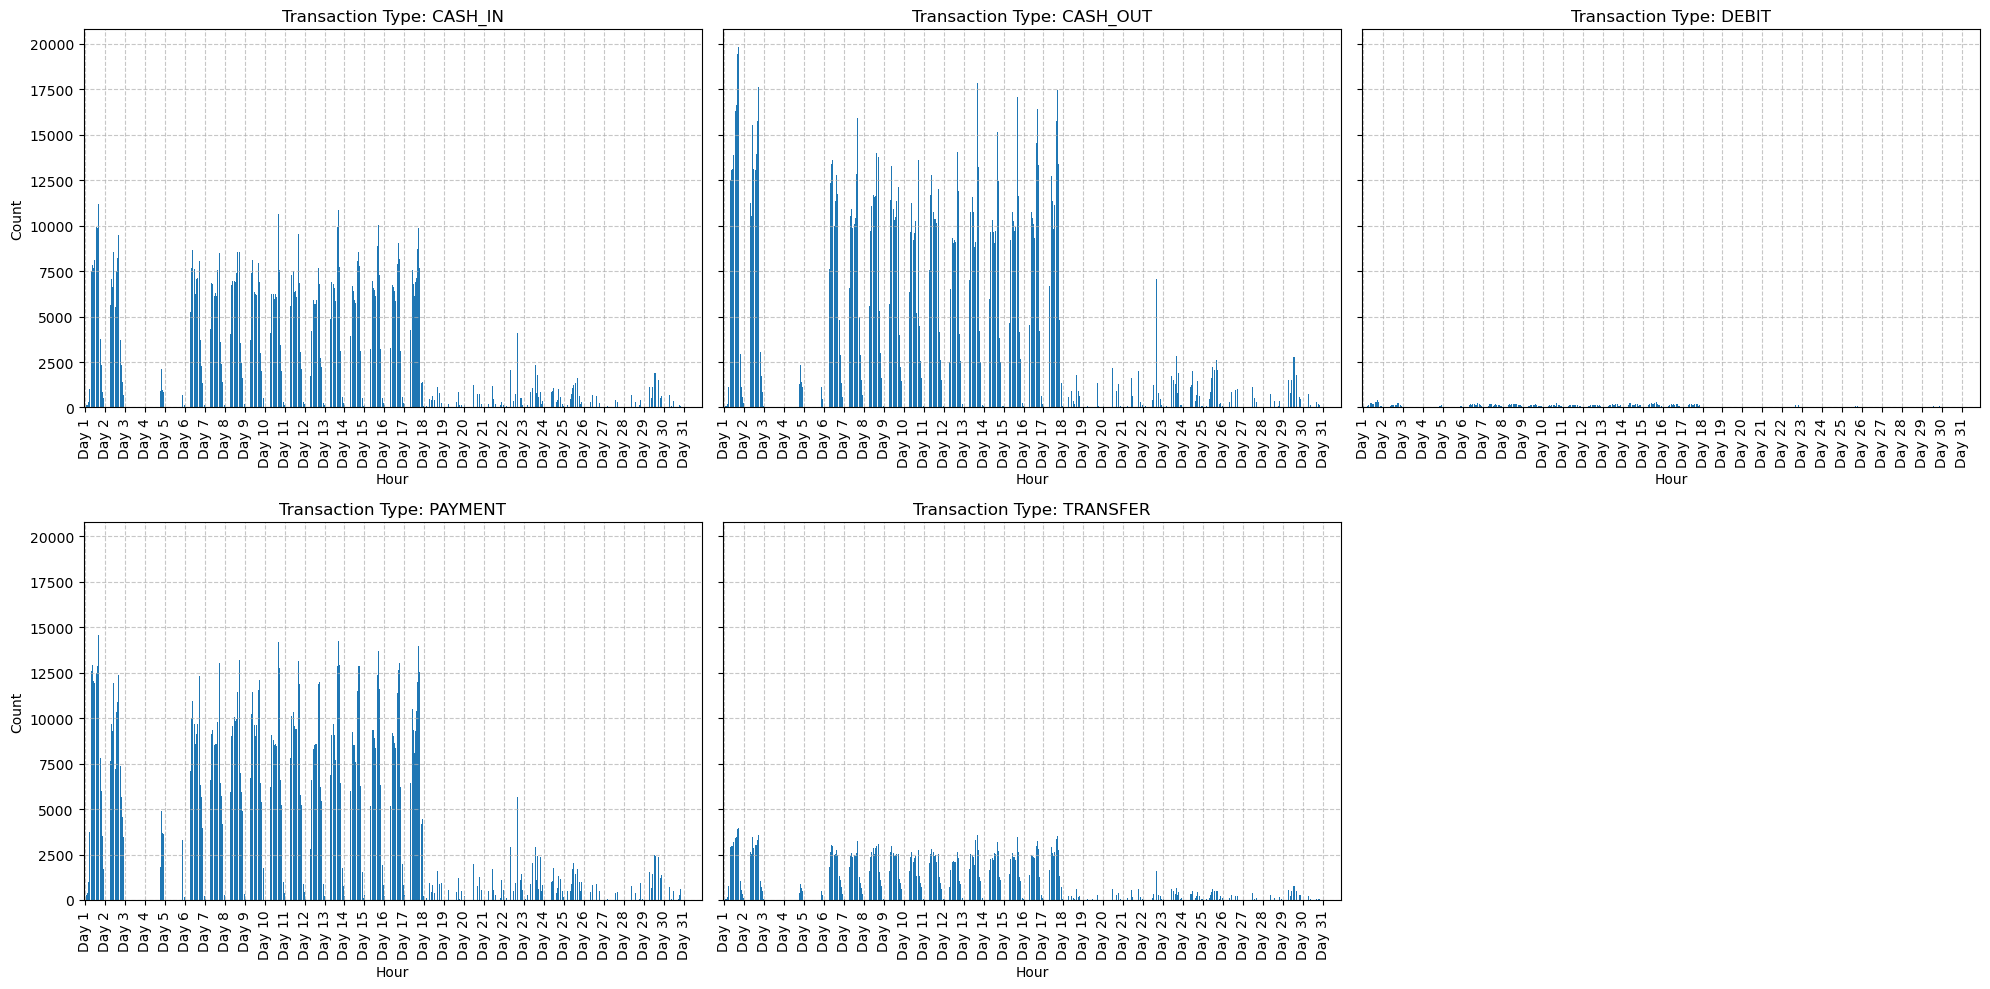

In [20]:
transaction_over_time = df.groupby(['step','type']).size().unstack()

fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
axes = axes.flatten()
types = ['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']

for idx,t_type in enumerate(types):
    if idx < len(axes):
        transaction_over_time[t_type].plot(ax=axes[idx], kind='bar', width=0.8)
        axes[idx].set_title(f'Transaction Type: {t_type}')
        axes[idx].set_xlabel('Hour')
        axes[idx].set_ylabel('Count')
        axes[idx].set_xticks(range(1, 744, 24))
        axes[idx].set_xticklabels([f'Day {i}' for i in range(1, 32)])
        axes[idx].grid(True, linestyle='--', alpha=0.7)

for idx in range(len(types), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

**Insight:**: In the above graphs we can see that the days Day 1 to Day 5 and Day 7 to Day 18 all the graphs show a common peak , What we can understand by this

- **CASH_IN & CASH_OUT**: Deposits in the bank as it peaks it could be because nameOrig doing the transaction and nameDest is receiving the amount
- **PAYMENT**: This could reflect scheduled payments or periodic financial events
- **DEBIT**: transactions are sparse throughout the 31 days, with counts rarely exceeding a few hundred.
- **TRANSFER**: The activity is more consistent than DEBIT but less intense than CASH_IN or CASH_OUT, suggesting regular transfer operations with periodic increases

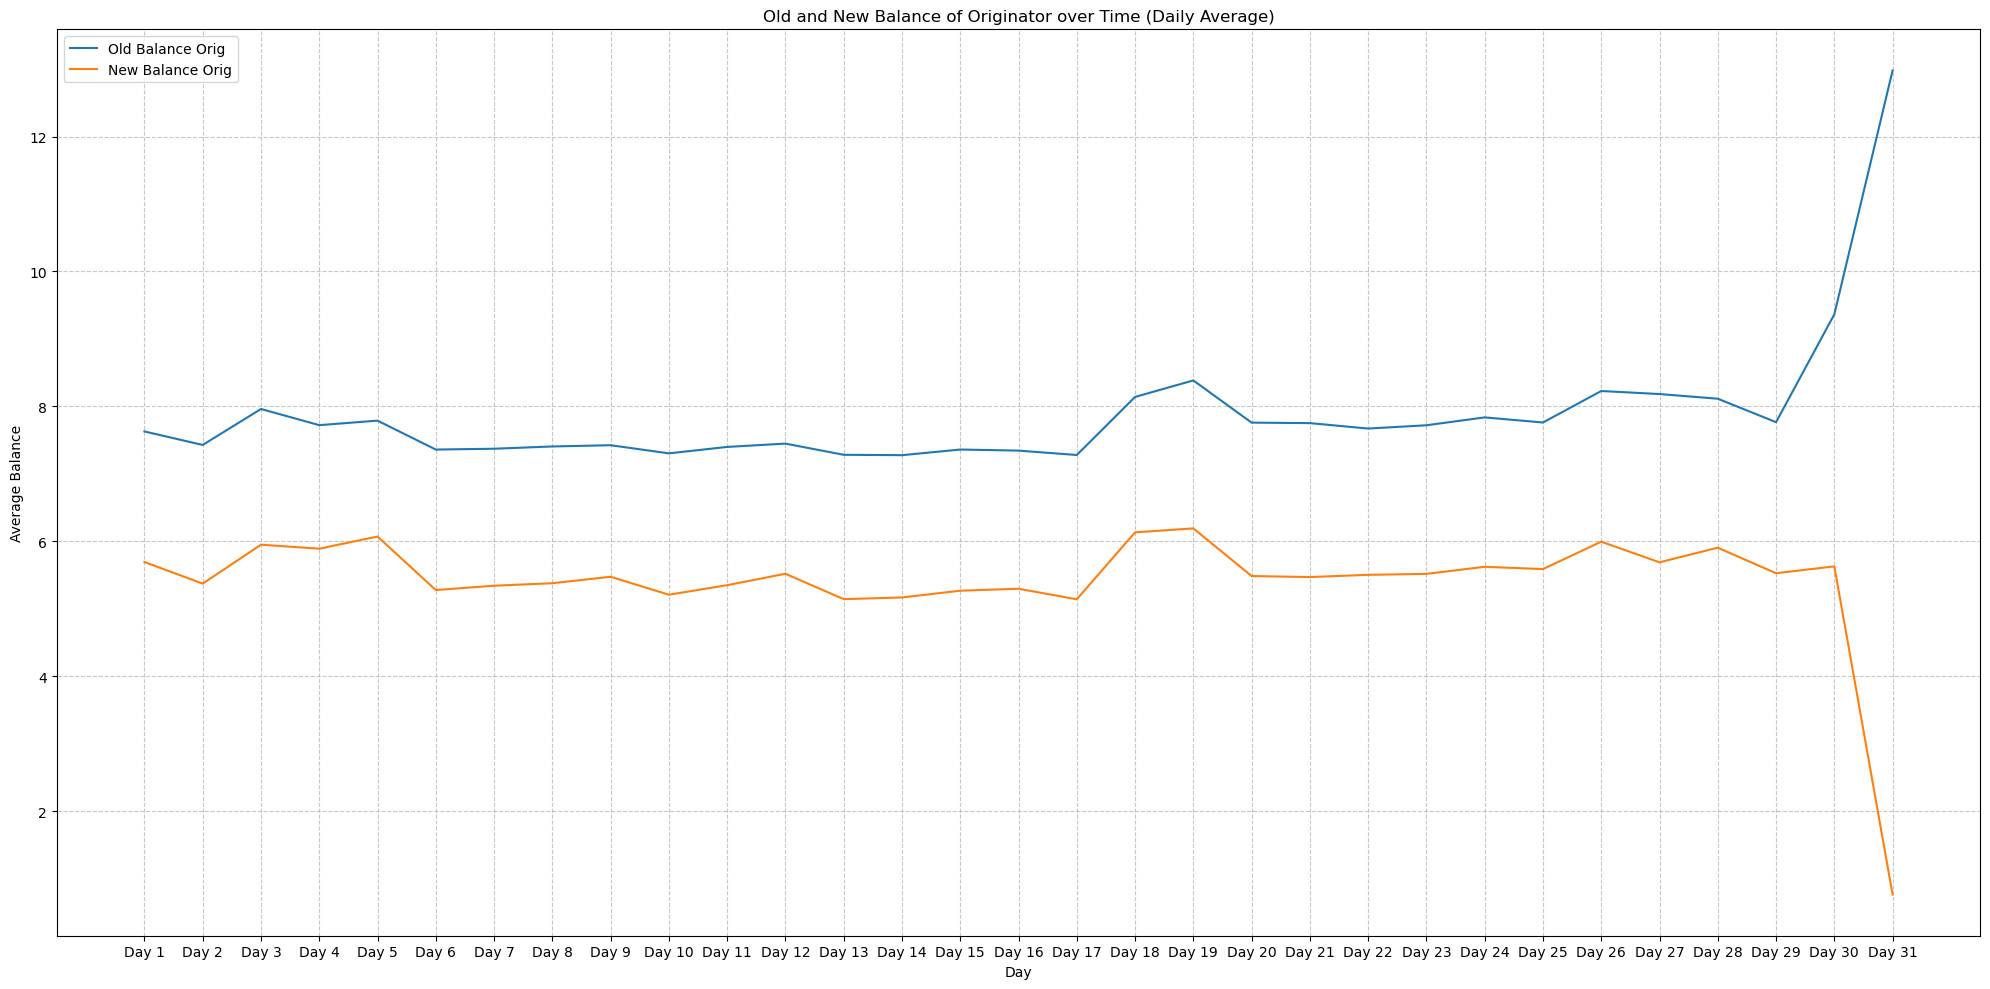

In [21]:
df_daily_before = df.groupby(df['step']//24).agg({'oldbalanceOrg': 'mean', 'newbalanceOrig': 'mean'}).reset_index()
df_daily_before['step'] = df_daily_before.index * 24 + 1

plt.figure(figsize=(20, 10))
plt.plot(df_daily_before['step'], df_daily_before['oldbalanceOrg'], label='Old Balance Orig', color='#1f77b4')
plt.plot(df_daily_before['step'], df_daily_before['newbalanceOrig'], label='New Balance Orig', color='#ff7f0e')
plt.title('Old and New Balance of Originator over Time (Daily Average)')
plt.xlabel('Day')
plt.ylabel('Average Balance')
plt.xticks(df_daily_before['step'], [f'Day {i+1}' for i in range(31)])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Insight:**: 
- Day 1 to Day 29: People were regularly transferring or using small portions of their money, keeping balances steady between 4 and 8 units.
- After Day 29: A big transfer or deposit happened, causing the old balance to jump to over 12 units, while the new balance stayed lower, showing some money was moved out.

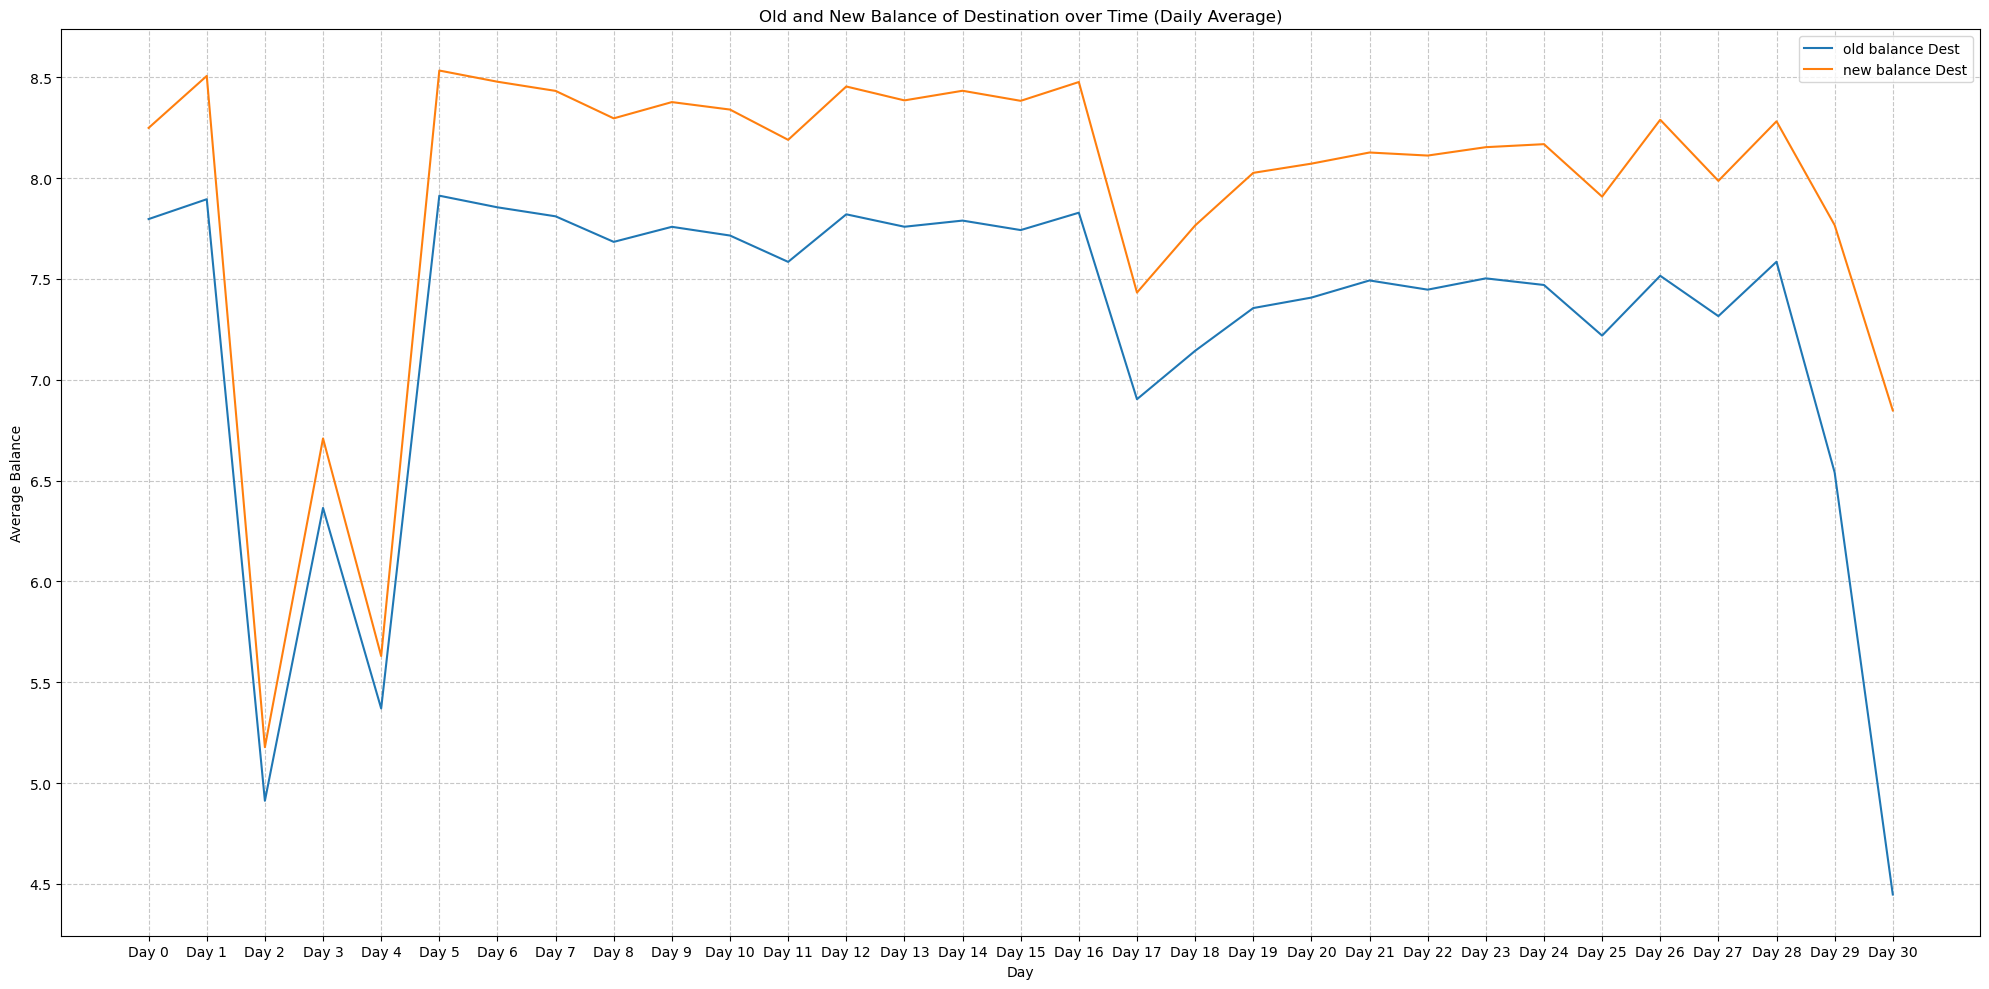

In [22]:
df_daily_after=df.groupby(df['step']//24).agg({'oldbalanceDest': 'mean', 'newbalanceDest': 'mean'}).reset_index()
df_daily_after['step'] = df_daily_after.index * 24 + 1

plt.figure(figsize=(20, 10))
plt.plot(df_daily_after['step'],df_daily_after['oldbalanceDest'],label='old balance Dest',color='#1f77b4')
plt.plot(df_daily_after['step'],df_daily_after['newbalanceDest'],label='new balance Dest',color='#ff7f0e')
plt.title('Old and New Balance of Destination over Time (Daily Average)')
plt.xlabel('Day')
plt.ylabel('Average Balance')
plt.xticks(df_daily_after['step'],[f"Day {i}" for i in range(31)])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Insight:**: 
- Day 1 to Day 29: The destination's balances remained stable, fluctuating between 5 and 8 units, suggesting regular small transfers or transactions were occurring
- After Day 29: A big transfer or deposit happened, causing the increase new balance of Receiver/Merchant this could also be explained by the significant dip in the newbalanceOrg

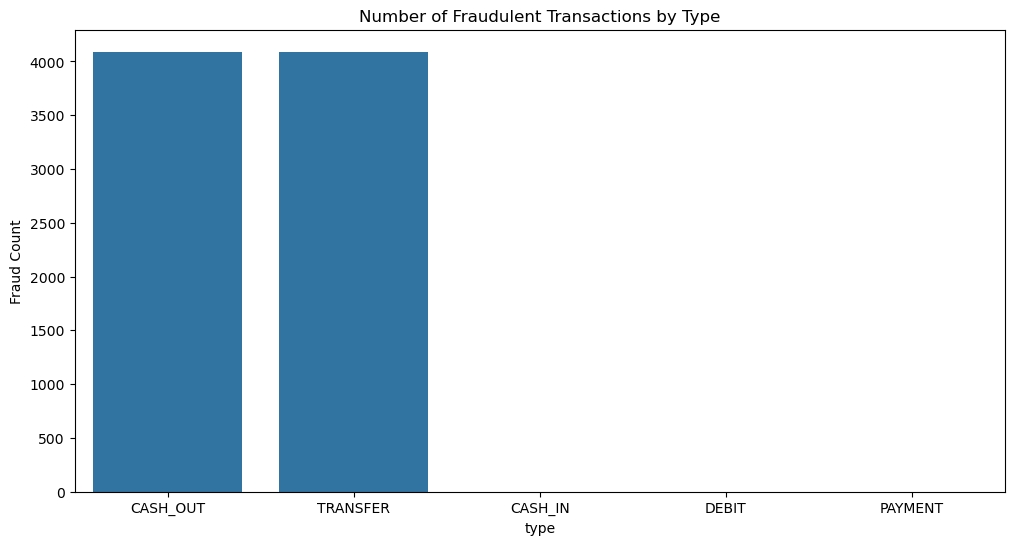

In [23]:
fraud_counts = df.groupby("type")["isFraud"].sum().reset_index()
fraud_counts = fraud_counts.sort_values("isFraud", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_counts, x="type", y="isFraud", order=fraud_counts["type"])
plt.title("Number of Fraudulent Transactions by Type")
plt.ylabel("Fraud Count")
plt.show()

In [24]:
fraud_counts

,type,isFraud
1,CASH_OUT,4090
4,TRANSFER,4087
0,CASH_IN,0
2,DEBIT,0
3,PAYMENT,0


**Insight:**
- As we can observe CASH_OUT & TRANSFER have the highest with a sum of 8177
    - Fraudsters TRANSFER money from a compromised account → then immediately CASH_OUT the funds
    - That’s why both types have frauds (and their counts are almost the same: 4090 and 4087)
- CASH_IN, DEBIT & PAYMENT have none
    - Fraudsters don’t bother with these types because they don’t help them extract money

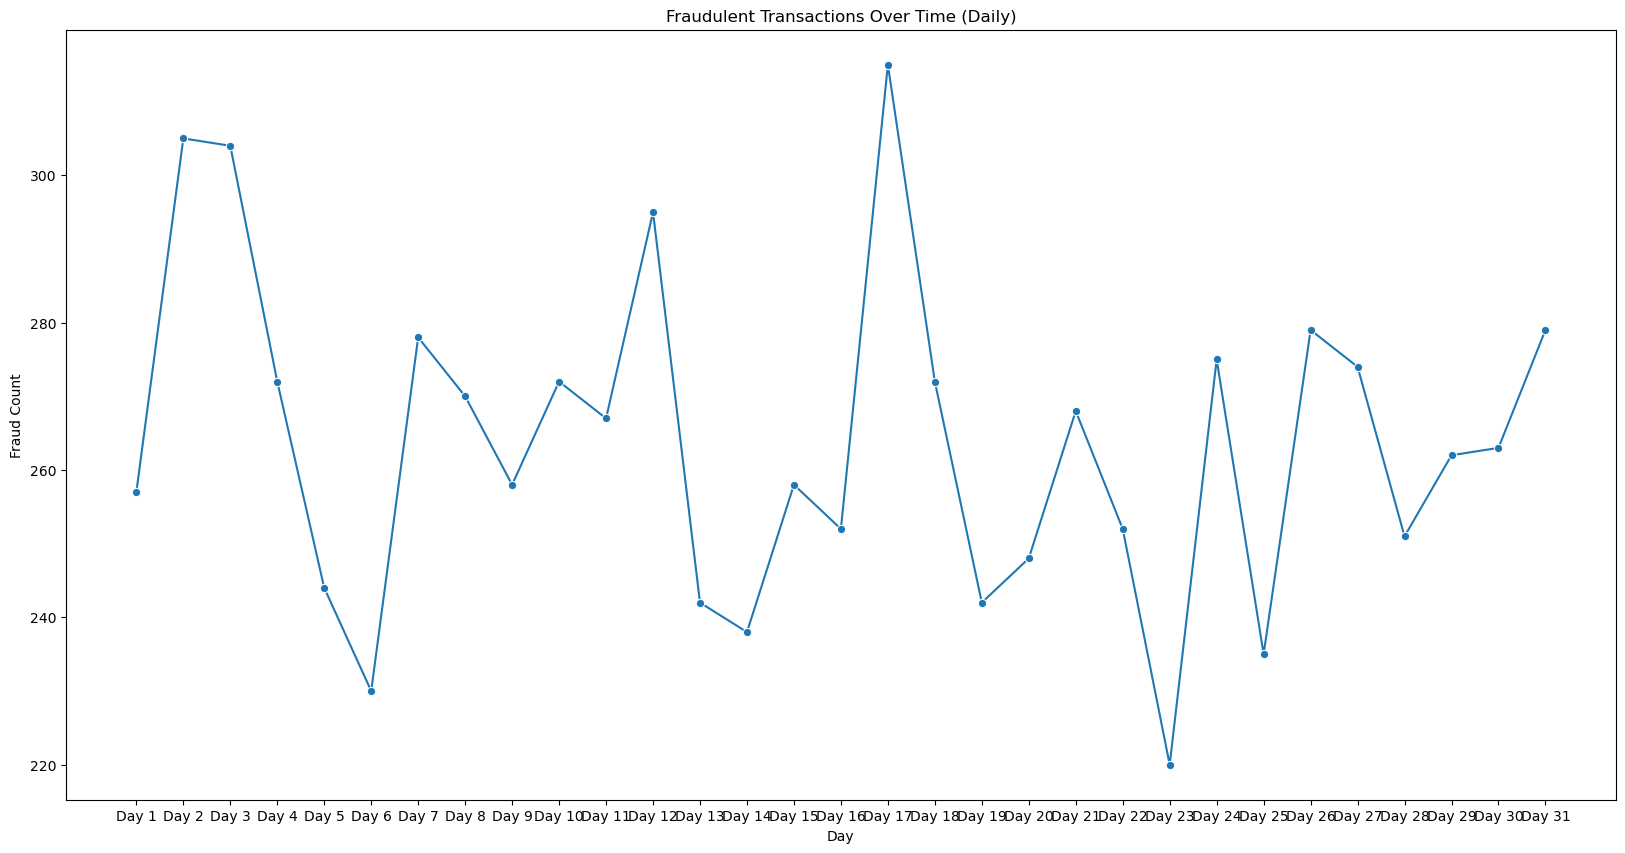

In [25]:
df["day"] = (df["step"] // 24) + 1
fraud_timeline_day = df[df["isFraud"] == 1].groupby("day")["isFraud"].sum().reset_index()

plt.figure(figsize=(20, 10))
sns.lineplot(data=fraud_timeline_day, x="day", y="isFraud", marker="o")
plt.title("Fraudulent Transactions Over Time (Daily)")
plt.xlabel("Day")
plt.ylabel("Fraud Count")
days = fraud_timeline_day["day"].unique()
plt.xticks(days, [f"Day {i}" for i in days])
plt.show()

**Insight:**
-   **Daily fraud counts fluctuate between ~220 and ~310**  
       - Lowest day: ~220 frauds.  
       - Highest peak: ~315 frauds.  
       - Fraud volume is relatively stable, with only moderate variation.
-    **Overall trend**  
       - No clear upward or downward trajectory.  
       - Fraud remains **persistent and steady throughout the month**.  

## Preprocessing

In [26]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day
0,1,PAYMENT,9.194276,C1231006815,12.044359,11.984786,M1979787155,0.000000,0.000000,0,0,1
1,1,PAYMENT,7.531166,C1666544295,9.964112,9.872292,M2044282225,0.000000,0.000000,0,0,1
4,1,PAYMENT,9.364703,C2048537720,10.634773,10.305174,M1230701703,0.000000,0.000000,0,0,1
5,1,PAYMENT,8.964275,C90045638,10.894162,10.737337,M573487274,0.000000,0.000000,0,0,1
6,1,PAYMENT,8.869085,C154988899,12.118312,12.078740,M408069119,0.000000,0.000000,0,0,1
7,1,PAYMENT,8.969878,C1912850431,12.078740,12.033067,M633326333,0.000000,0.000000,0,0,1
8,1,PAYMENT,8.300370,C1265012928,7.890583,0.000000,M1176932104,0.000000,0.000000,0,0,1
9,1,DEBIT,8.582751,C712410124,10.638760,10.501863,C195600860,10.643017,10.605341,0,0,1
10,1,DEBIT,9.174292,C1900366749,8.404248,0.000000,C997608398,9.291552,11.970243,0,0,1
11,1,PAYMENT,8.039470,C249177573,9.941361,9.779738,M2096539129,0.000000,0.000000,0,0,1


In [27]:
num_features =df.select_dtypes(include=['int64','float64']).drop(columns=['isFraud','isFlaggedFraud'], errors='ignore')

X=add_constant(num_features)

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,Feature,VIF
0,const,64.133215
1,step,1092.934784
2,amount,1.971240
3,oldbalanceOrg,2.737889
4,newbalanceOrig,2.934866
5,oldbalanceDest,5.213775
6,newbalanceDest,5.927913
7,day,1092.999143


**Insight:**
- Interpretation of VIF
    * const = 61.45 → Ignore this, it’s the intercept term, always high.
    * step = 1.00 → Perfect, no correlation issues.
    * amount ≈ 1.96 → Very low correlation → no problem.
    * oldbalanceOrg ≈ 2.73 → Acceptable (well below 5).
    * newbalanceOrig ≈ 2.93 → Acceptable.
    * oldbalanceDest ≈ 5.21 → Slightly above the “safe” threshold (5).
    * newbalanceDest ≈ 5.92 → Moderate multicollinearity.
- No severe multicollinearity No need for PCA

## Feature Engineering

In [28]:
df["orig_is_customer"] = df["nameOrig"].str.startswith("C").astype(int)
df["dest_is_customer"] = df["nameDest"].str.startswith("C").astype(int)
df["dest_is_merchant"] = df["nameDest"].str.startswith("M").astype(int)

* This immediately tells you if money is flowing into merchants or other customers, which is very useful

In [29]:
df["orig_txn_count"] = df.groupby("nameOrig")["nameOrig"].transform("count")
df["dest_txn_count"] = df.groupby("nameDest")["nameDest"].transform("count")

* Count how many transactions each account makes / receives.
* Fraudsters often have short-lived, very active accounts.

In [30]:
df["pair_txn_count"] = df.groupby(["nameOrig", "nameDest"])["step"].transform("count")

Fraud often uses same pair repeatedly until balance is emptied

In [31]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,orig_is_customer,dest_is_customer,dest_is_merchant,orig_txn_count,dest_txn_count,pair_txn_count
0,1,PAYMENT,9.194276,C1231006815,12.044359,11.984786,M1979787155,0.000000,0.000000,0,0,1,1,0,1,1,1,1
1,1,PAYMENT,7.531166,C1666544295,9.964112,9.872292,M2044282225,0.000000,0.000000,0,0,1,1,0,1,1,1,1
4,1,PAYMENT,9.364703,C2048537720,10.634773,10.305174,M1230701703,0.000000,0.000000,0,0,1,1,0,1,1,1,1
5,1,PAYMENT,8.964275,C90045638,10.894162,10.737337,M573487274,0.000000,0.000000,0,0,1,1,0,1,1,1,1
6,1,PAYMENT,8.869085,C154988899,12.118312,12.078740,M408069119,0.000000,0.000000,0,0,1,1,0,1,1,1,1
7,1,PAYMENT,8.969878,C1912850431,12.078740,12.033067,M633326333,0.000000,0.000000,0,0,1,1,0,1,1,1,1
8,1,PAYMENT,8.300370,C1265012928,7.890583,0.000000,M1176932104,0.000000,0.000000,0,0,1,1,0,1,1,1,1
9,1,DEBIT,8.582751,C712410124,10.638760,10.501863,C195600860,10.643017,10.605341,0,0,1,1,1,0,1,34,1
10,1,DEBIT,9.174292,C1900366749,8.404248,0.000000,C997608398,9.291552,11.970243,0,0,1,1,1,0,1,59,1
11,1,PAYMENT,8.039470,C249177573,9.941361,9.779738,M2096539129,0.000000,0.000000,0,0,1,1,0,1,1,1,1


* Dropping nameOrig, nameDest cuz we have already made orig_is_customer, dest_is_customer, dest_is_merchant

## Model Training

In [32]:
X = df.drop(columns=['isFraud','isFlaggedFraud','nameOrig','nameDest'])
y = df['isFraud']

### Why `isFlaggedFraud` was dropped

- `isFlaggedFraud` is **not a genuine feature** of the transaction data but a **rule-based flag** artificially introduced in the simulator.  
- It is set to **1** only when a `TRANSFER` transaction amount exceeds 200,000.  
- Including this column in model training would lead to **data leakage**, as the model would simply learn to replicate this predefined rule rather than discovering underlying fraud patterns.  
- Moreover, this rule is very limited in scope: it only catches a tiny fraction of fraud cases, while most fraud transactions remain unflagged.  
- Therefore, we drop `isFlaggedFraud` from the training features and use only `isFraud` as the target label.  
- The column is retained only for **evaluation purposes**, to compare the performance of this simple rule against the machine learning model.


* Building pipeline for the model

In [33]:
numeric_features = ['amount','oldbalanceOrg','newbalanceOrig','newbalanceDest','oldbalanceDest']
categorical_features = ['type']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

* Spliting Data for test and train

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

* Using LogisticRegression

In [90]:
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced',max_iter=1000))
])
lr_model.fit(X_train,y_train)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

* Using XGBClassifier

In [94]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    tree_method="hist", 
    device="cuda",
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    random_state=42
)

xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

* Using CatBoost

In [92]:
cat = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    task_type='GPU',          
    eval_metric='AUC',
    class_weights=[1, 100],
    random_seed=42,
    verbose=100
)

cat_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', cat)
])

cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 244ms	remaining: 4m 3s
100:	total: 4.52s	remaining: 40.3s
200:	total: 8.83s	remaining: 35.1s
300:	total: 12.9s	remaining: 30.1s
400:	total: 17.1s	remaining: 25.5s
500:	total: 21.2s	remaining: 21.1s
600:	total: 25.2s	remaining: 16.8s
700:	total: 29.4s	remaining: 12.5s
800:	total: 33.6s	remaining: 8.34s
900:	total: 37.8s	remaining: 4.15s
999:	total: 42s	remaining: 0us


## Evaluating Model

In [95]:
print("Logistic Regression Performance")
print(classification_report(y_test,lr_pred, zero_division=0))
print("XGBClassifier Performance")
print(classification_report(y_test,xgb_pred, zero_division=0))
print("CatBoostClassifier Performance")
print(classification_report(y_test,cat_pred, zero_division=0))

Logistic Regression Performance
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1264404
           1       0.03      0.99      0.05      1635

    accuracy                           0.96   1266039
   macro avg       0.51      0.97      0.52   1266039
weighted avg       1.00      0.96      0.98   1266039

XGBClassifier Performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1264404
           1       0.65      0.94      0.77      1635

    accuracy                           1.00   1266039
   macro avg       0.83      0.97      0.89   1266039
weighted avg       1.00      1.00      1.00   1266039

CatBoostClassifier Performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1264404
           1       0.41      0.99      0.58      1635

    accuracy                           1.00   1266039
   macro avg       0.70      1.00      

In [96]:
xgb_pred_auc = xgb_model.predict_proba(X_test)[:,1]
cat_pred_auc = cat_model.predict_proba(X_test)[:,1]
lr_pred_auc = lr_model.predict_proba(X_test)[:,1]

In [100]:
print("Logistic Regression Performance")
print("ROC-AUC:", roc_auc_score(y_test, lr_pred_auc))
print("PR-AUC :", average_precision_score(y_test, lr_pred_auc),"\n")
print("CatBoostClassifier Performance")
print("ROC-AUC:", roc_auc_score(y_test, cat_pred_auc))
print("PR-AUC :", average_precision_score(y_test, cat_pred_auc),"\n")
print("XGBClassifier Performance")
print("ROC-AUC:", roc_auc_score(y_test, xgb_pred_auc))
print("PR-AUC :", average_precision_score(y_test, xgb_pred_auc))

Logistic Regression Performance
ROC-AUC: 0.9958065042637682
PR-AUC : 0.5966274076482607 

CatBoostClassifier Performance
ROC-AUC: 0.9993165016538912
PR-AUC : 0.9264808832780754 

XGBClassifier Performance
ROC-AUC: 0.9989875552879214
PR-AUC : 0.9325417708955042


## Feature Importance

In [109]:
print("Logistic Regression Performance")
log_model_inside = lr_model.named_steps['classifier']

importance = abs(log_model_inside.coef_[0])
features = X_train.columns 

for f, imp in zip(features, importance):
    print(f"{f}: {imp}")

Logistic Regression Performance
step: 2.1141229342221717
type: 10.80947902779389
amount: 3.7607335361592567
oldbalanceOrg: 3.0374290691110626
newbalanceOrig: 0.2686099895040008
oldbalanceDest: 11.824401668281032
newbalanceDest: 0.39465883249393874
day: 15.70353666531296
orig_is_customer: 11.064704745478673


In [110]:
print("CatBoostClassifier Performance")
cat_model_inside = cat_model.named_steps['classifier']

importance = cat_model_inside.get_feature_importance()
features = X_train.columns

for f, imp in zip(features, importance):
    print(f"{f}: {imp}")

CatBoostClassifier Performance
step: 28.64449245166529
type: 34.90101548715015
amount: 14.745561514960297
oldbalanceOrg: 4.836094169418288
newbalanceOrig: 5.8363219507397615
oldbalanceDest: 8.030600936675071
newbalanceDest: 0.0
day: 1.4983757584705681
orig_is_customer: 1.5075377309205718


In [111]:
print("XGBClassifier Performance")
xgb_model_inside = xgb_model.named_steps['classifier']

importance = xgb_model_inside.feature_importances_
features = X_train.columns

for f, imp in zip(features, importance):
    print(f"{f}: {imp}")

XGBClassifier Performance
step: 0.010313725098967552
type: 0.026637598872184753
amount: 0.6351189017295837
oldbalanceOrg: 0.0025514329317957163
newbalanceOrig: 0.0003811684437096119
oldbalanceDest: 0.006824985146522522
newbalanceDest: 0.005096235312521458
day: 0.2865767180919647
orig_is_customer: 0.026499243453145027


# Fraud Detection Analysis

We evaluated three models — **Logistic Regression**, **CatBoost**, and **XGBoost** — on our dataset with 1,266,039 transactions, including 1,635 fraudulent transactions.  

---

## 1. Model Performance Overview

| Model | ROC-AUC | PR-AUC | Fraud Recall | Fraud Precision | F1-score (Fraud) |
|-------|---------|--------|--------------|----------------|----------------|
| Logistic Regression | 0.996 | 0.60 | 0.99 | 0.03 | 0.05 |
| CatBoost | 0.999 | 0.93 | 0.99 | 0.41 | 0.58 |
| XGBoost | 0.999 | 0.93 | 0.94 | 0.65 | 0.77 |

**Observations:**

- Logistic Regression has very high recall but extremely low precision → it predicts almost all frauds but generates many false positives.  
- CatBoost and XGBoost are much better for imbalanced datasets, with high ROC-AUC and PR-AUC.  
- XGBoost balances recall and precision slightly better than CatBoost.  

---

## 2. Feature Importance Analysis

### Key Features Across Models

| Feature | Logistic Regression | CatBoost | XGBoost | Interpretation |
|---------|------------------|----------|---------|----------------|
| `type` | 10.81 | 34.90 | 0.03 | Transaction type is the most predictive; certain types like TRANSFER or CASH_OUT are more likely fraudulent. |
| `step` | 2.11 | 28.64 | 0.01 | Transaction timing plays a role; fraud often occurs at specific time intervals. |
| `amount` | 3.76 | 14.75 | 0.63 | Larger transaction amounts are more likely to be fraudulent. |
| `oldbalanceOrg` | 3.03 | 4.83 | 0.0025 | Unusual sender balances can indicate fraud. |
| `newbalanceOrig` | 0.27 | 5.83 | 0.00038 | Abrupt balance changes in sender account signal suspicious activity. |
| `oldbalanceDest` | 11.82 | 8.03 | 0.0068 | Abnormal recipient balances are indicative of fraud. |
| `newbalanceDest` | 0.39 | 0.0 | 0.0050 | Zeroing or sudden changes in destination accounts can indicate fraud. |
| `day` | 15.70 | 1.50 | 0.28 | Certain days of the week or month see more fraudulent activity. |
| `orig_is_customer` | 11.06 | 1.50 | 0.0265 | Transactions from non-verified customers are more likely fraudulent. |

---

## 3. Key Takeaways

1. **Most predictive features for fraud detection**:
   - `type` (transaction type)
   - `amount` (transaction size)
   - `step` (transaction timing)
   - `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest` (unusual balance changes)
   - `orig_is_customer` (whether sender is a verified customer)

2. **Model recommendations**:
   - **XGBoost**: Best balance between recall and precision.  
   - **CatBoost**: Maximizes recall → detects nearly all fraudulent transactions.  
   - **Logistic Regression**: High recall but too many false positives → not ideal alone.  

3. **Business insight**:
   - Fraudulent transactions tend to be **large, unusual transfers**, often **from unverified customers**, and occur **at specific times or transaction types**.  
   - Monitoring these key factors can help **proactively detect and prevent fraud**.


# Do These Factors Make Sense?

Based on the feature importance analysis and domain understanding, the identified factors **do make sense** in the context of predicting fraudulent transactions. Here's a breakdown:

---

## 1. `type` (Transaction Type)
**Why it makes sense:**  
- Fraud often occurs through specific types of transactions, such as **TRANSFERS** or **CASH_OUT**.  
- These types are easier to exploit compared to standard deposits or payments.  
- Tree-based models (CatBoost/XGBoost) highlight this feature as the most predictive, which aligns with real-world observations.

---

## 2. `amount` (Transaction Amount)
**Why it makes sense:**  
- Fraudsters usually attempt **large or unusual transactions** to move significant money.  
- Very small transactions are less profitable to fraudsters.  
- This aligns with the model's high importance score for `amount`.

---

## 3. `step` (Transaction Timing)
**Why it makes sense:**  
- Fraud often occurs at **specific times**, such as unusual hours or burst periods.  
- Monitoring timing patterns can reveal suspicious activity that deviates from normal behavior.  

---

## 4. `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest` (Balances)
**Why it makes sense:**  
- Fraudulent transactions often cause **abnormal changes in account balances**, such as:  
  - Sending large amounts that zero out the account (`newbalanceOrig` close to 0)  
  - Abnormal deposits into the destination account  
- These features are logical indicators of fraud because they reflect **suspicious money flows**.

---

## 5. `orig_is_customer` (Is Originator a Verified Customer)
**Why it makes sense:**  
- Transactions initiated by **unverified or new accounts** are riskier.  
- Fraudsters often use accounts that are not well-established or anonymous to avoid detection.  

---

## 6. `day` (Day of Transaction)
**Why it makes sense:**  
- Some days may see **more fraudulent activity**, such as weekends or holidays when monitoring may be lower.  
- Models like XGBoost capture this subtle temporal pattern.  

---

## ✅ Summary
All these factors are **intuitively aligned with how financial fraud occurs in real life**:

- Fraudsters target specific transaction types and large amounts.  
- They manipulate balances to move money quickly.  
- Timing and account verification status are natural risk indicators.  

**Conclusion:**  
The model’s findings are **consistent with practical knowledge of fraudulent behavior**, which validates both the model and the selected features.


# Fraud Prevention Based on Model Insights

- **Monitor high-risk transaction types (`type`)**: Flag transfers or cash-out transactions that are commonly fraudulent.  
- **Set limits or alerts for large transactions (`amount`)**: Unusually high amounts should trigger review.  
- **Track transaction timing (`step` and `day`)**: Watch for unusual patterns or bursts at specific times.  
- **Verify account balances (`oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`)**: Sudden or suspicious balance changes should be flagged.  
- **Check customer verification (`orig_is_customer`)**: Give extra scrutiny to transactions from new or unverified accounts.  

# Checking if Fraud Prevention Works

- **Monitor metrics**: Track fraud detection rate, precision, recall, and PR-AUC.  
- **Compare before and after**: Check if fraudulent transactions are caught more effectively.  
- **Review flagged transactions**: Ensure alerts correspond to real fraud and adjust thresholds.  
- **Continuous feedback**: Update the model with new data to keep detection accurate.
